In [1]:
import matplotlib.pyplot as plt
import emcee
import numpy as np
import batman
import scipy.stats
import pickle
from multiprocessing import Pool
import pygtc
import corner

%matplotlib widget

In [2]:
taste_dictionary = pickle.load((open('../Results/TASTE/diff_dictionary.p', 'rb')))
bjd_taste = taste_dictionary['time']
flux_taste = pickle.load((open('../Results/TASTE/differential_allref.p', 'rb')))
flux_error_taste = pickle.load((open('../Results/TASTE/differential_allref_err.p', 'rb')))

###############################################################################################

tess_dictionary23 = pickle.load((open('../Results/TESS/sector23_flatten.p', 'rb')))
bjd_tess23 = tess_dictionary23['time']
flux_tess23 = tess_dictionary23['pdcsap_masked_hspline_flux']
flux_error_tess23 = tess_dictionary23['pdcsap_masked_hspline_flux_error']

###############################################################################################

tess_dictionary49 = pickle.load((open('../Results/TESS/sector49_flatten.p', 'rb')))
bjd_tess49 = tess_dictionary49['time']
flux_tess49 = tess_dictionary49['pdcsap_masked_bw_flux']
flux_error_tess49 = tess_dictionary49['pdcsap_masked_bw_flux_error']

###############################################################################################

tess_dictionary50 = pickle.load((open('../Results/TESS/sector50_flatten.p', 'rb')))
bjd_tess50 = tess_dictionary50['time']
flux_tess50 = tess_dictionary50['pdcsap_masked_hspline_flux']
flux_error_tess50 = tess_dictionary50['pdcsap_masked_hspline_flux_error']

###############################################################################################

tess_dictionary76 = pickle.load((open('../Results/TESS/sector76_flatten.p', 'rb')))
bjd_tess76 = tess_dictionary76['time']
flux_tess76 = tess_dictionary76['pdcsap_masked_bw_flux']
flux_error_tess76 = tess_dictionary76['pdcsap_masked_bw_flux_error']

bjd_tess = [bjd_tess23, bjd_tess49, bjd_tess50, bjd_tess76]
flux_tess = [flux_tess23, flux_tess49, flux_tess50, flux_tess76]
flux_error_tess = [flux_error_tess23, flux_error_tess49, flux_error_tess50, flux_error_tess76]

In [3]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    chi2_tess = []
    sum_ln_sigma_tess = []

    for i in range(0, 4):
        m_tess = batman.TransitModel(params, bjd_tess[i])
        tess_model = m_tess.light_curve(params)
        tess_errors_with_jitter = flux_error_tess[i]**2 + theta[12]**2
        chi2_tess = np.append(np.sum((flux_tess[i]-tess_model)**2 / tess_errors_with_jitter), chi2_tess)
        sum_ln_sigma_tess = np.append(np.sum(np.log(tess_errors_with_jitter)), sum_ln_sigma_tess)

    params.u = [theta[7] , theta[8]]

    median_bjd = np.median(bjd_taste)
    polynomial_trend = theta[9]+theta[10]*(bjd_taste-median_bjd) + theta[11]*(bjd_taste-median_bjd)**2
    
    m_taste = batman.TransitModel(params, bjd_taste)
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    taste_errors_with_jitter = flux_error_taste**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_taste = np.sum((flux_taste-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess[0] + chi2_tess[1] + chi2_tess[2] + chi2_tess[3] + chi2_taste + 
                             sum_ln_sigma_tess[0] + sum_ln_sigma_tess[1] + sum_ln_sigma_tess[2] + sum_ln_sigma_tess[3] + sum_ln_sigma_taste)
    return log_likelihood

def log_prior(theta):
    prior = 0.00
    prior+= np.log(scipy.stats.norm.pdf(theta[5], loc=0.5011, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[6], loc=0.1396, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[7], loc=0.6367, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[8], loc=0.1300, scale=0.10))
    return prior

def log_posterior(theta):

    boundaries = np.empty([2, len(theta)])

    boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
    boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
    boundaries[:,2] = [0.0, 0.5]
    boundaries[:,3] = [0.0, 20.]
    boundaries[:,4] = [80.0, 90.0]
    boundaries[:,5] = [0.00, 1.0]
    boundaries[:,6] = [0.00, 1.0]
    boundaries[:,7] = [0.00, 1.0]
    boundaries[:,8] = [0.00, 1.0]
    boundaries[:,9] = [0.0, 1.0]
    boundaries[:,10] = [-1.0, 1.0]
    boundaries[:,11] = [-1.0, 1.0]
    boundaries[:,12] = [0.0, 0.05]
    boundaries[:,13] = [0.0, 0.05]
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_post = log_prior(theta)

    log_post += log_likelihood(theta)
    return log_post

In [4]:
#theta
#0: t0
#1: period
#2: planet radius
#3: a
#4: i
#5: u1 TESS
#6: u2 TESS
#7: u1 TASTE
#8: u2 TASTE
#9: 0th order coeff
#10: 1st order coeff
#11: 2nd order coeff
#12: jitter TESS
#13: jitter TASTE

In [5]:
theta = np.empty(14)

theta[0] = 2459685.398095
theta[1] = 3.2130578
theta[2] = 0.1406
theta[3] = 11.77
theta[4] = 89.0
theta[5] = 0.5011
theta[6] = 0.1396
theta[7] = 0.6367
theta[8] = 0.1300
theta[9] = 0.6615
theta[10] = 0.0
theta[11] = 0.0
theta[12] = 0.0
theta[13] = 0.0

In [6]:
#Run the MCMC

nwalkers = 50
nsteps = 20000
ndim = len(theta)
starting_point = theta + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

In [7]:
with Pool() as pool:
    mcmc = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
    run_one = mcmc.run_mcmc(starting_point, nsteps, progress=True)

100%|██████████| 20000/20000 [04:56<00:00, 67.52it/s]


In [8]:
#print(run_one)

Text(0.5, 0, 'step number')

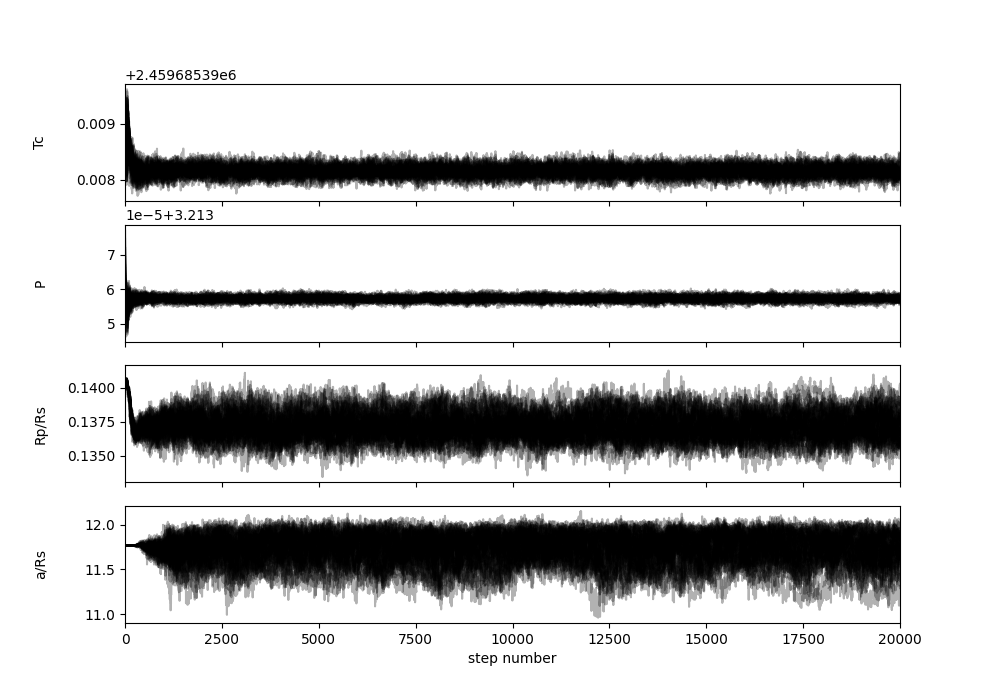

In [9]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = mcmc.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [10]:
flat_samples = mcmc.get_chain(discard=5000, flat=True, thin=100)
np.shape(flat_samples)

(7500, 14)

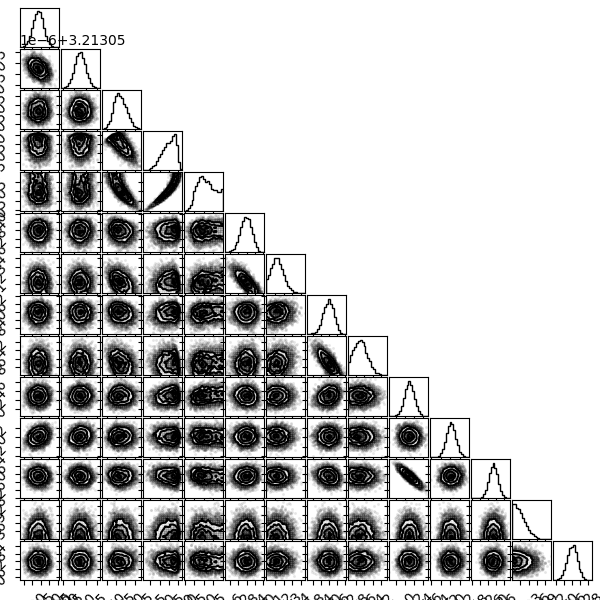

In [11]:
#GTC = pygtc.plotGTC(chains=samples[:, 0])

fig = plt.figure(figsize=(6, 6))
corner.corner(flat_samples, fig=fig)
plt.show()

In [12]:
pickle.dump(mcmc, open('../Results/MCMC/taste_tess(t)_v2.p','wb'))
#mcmc = pickle.load(open('../Results/MCMC/emcee_sampler_first_run.p','rb'))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

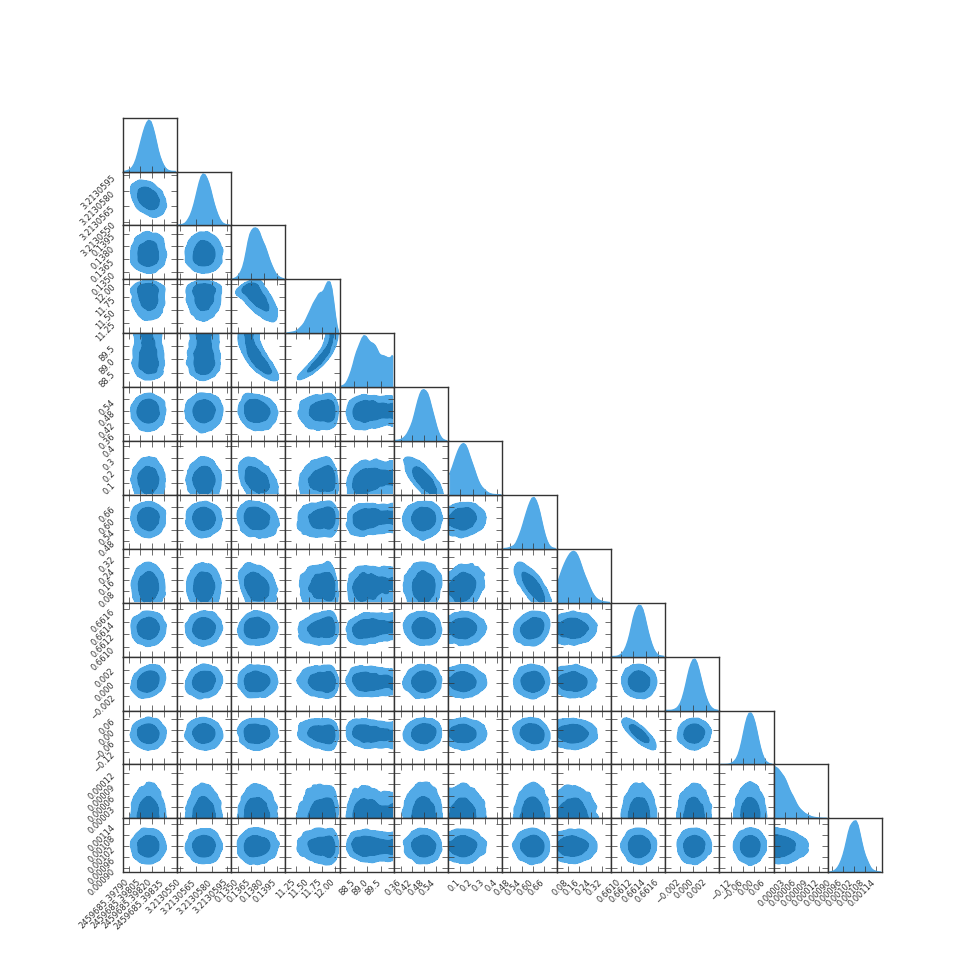

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [14]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$LD_1^TESS$',
         '$LD_2^TESS$')

GTC = pygtc.plotGTC(chains=flat_samples)